ЦЕЛЬ:

 Подготовить основу рекомендательной системы, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повысить средний чек.

ЗАДАНИЕ:

1) Познакомиться с датасетом, подготовить и проанализировать данные с помощью
SQL.

2) Обработать данные средствами Python.

3) Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.

4) Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import sort
import plotly

Посчитаем сколько клиентов купили больше одного курса:

In [ ]:
# Выполнение запроса SQL и преобразование в DataFrame
def get_users_count():
    query = '''WITH num_courses AS(
    SELECT user_id, count (resource_id)
    FROM final.cart_items AS items
    JOIN final.carts ON items.cart_id = carts.id
    WHERE resource_type = 'Course' AND state = 'successful'
    GROUP BY 1
    HAVING count (distinct resource_id) > 1
    )
    SELECT count (user_id)
    FROM num_courses
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

users_count = pd.DataFrame(get_users_count())
users_count # 12656 клиентов купило больше одного курса

,count
0,12656


In [ ]:
# Выполнение запроса SQL и преобразование в DataFrame
def get_data_sql():
    query = '''WITH num_courses AS(
    SELECT
    user_id,
    count (resource_id)
    FROM final.cart_items AS items
    JOIN final.carts ON items.cart_id = carts.id
    WHERE resource_type = 'Course' AND state = 'successful'
    GROUP BY 1
    HAVING count (distinct resource_id) > 1
    )

    SELECT
    distinct num_courses.user_id,
    resource_id
    FROM num_courses
    JOIN final.carts ON num_courses.user_id = carts.user_id
    JOIN final.cart_items AS items ON items.cart_id = carts.id
    WHERE resource_type = 'Course' AND state = 'successful'
    ORDER BY 1,2
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


Разобьём все покупки курсов по парам, после чего ранжируйте их для каждого курса.

In [ ]:
# Определим все вариации курсов в покупках клиентов
get_data = pd.DataFrame(get_data_sql())
pair = get_data.groupby('user_id')['resource_id'].apply(lambda x: list(np.unique(x))).reset_index()
pairs = pd.DataFrame(pair['resource_id'].apply(lambda x: list(combinations(x, 2))))
pairs_list = pairs['resource_id'].to_list()
list_pair = []
for item in pairs_list:
    for i in item:
        list_pair.append(i)

set_pair = set(list_pair)
len(set_pair) # всего в покупках клиентов встречаются вместе 3989 различных пар курсов
count_pair = Counter(list_pair)
most_count_pair = count_pair.most_common(1) # самая популярная пара курсов с id 551 и 566, встречаются 797 раз

In [ ]:
# Преобразуем счётчик пар курсов в DataFrame для получения статистических данных
df_count_pair = pd.DataFrame.from_dict(count_pair, orient='index').reset_index()
df_count_pair = df_count_pair.rename(columns={'index':'pair', 0:'count'})
df_count_pair = df_count_pair.sort_values(by='count', ascending=False).reset_index(drop=True)
df_count_pair.describe()

,count
count,3989.000000
mean,10.031838
std,26.355998
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,797.000000


Минимальная граница для рекомендации курсов:

В качестве минимальной границы при определении популярности пар курсов возьмём данные равные, либо выше третьего квартиля.
Выборка останется достаточно большой, при этом из рекомендаций исключим редко встречающие курсы.


Text(0.5, 1.0, 'Частота покупки курсов для выборки среди пар курсов,\n встречающихся в корзинах равныи или более 9 раз')

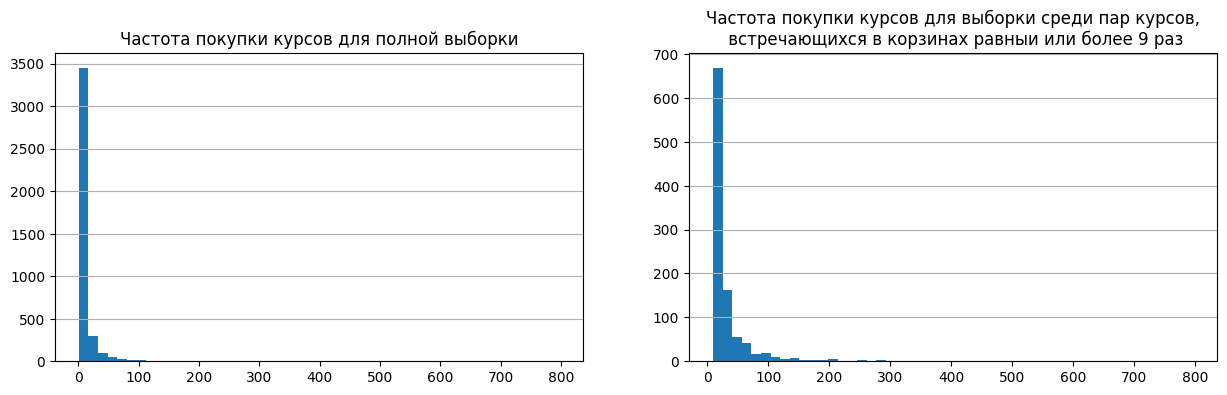

In [ ]:
# DataFrame популярных пар курсов
count_popular_pair = df_count_pair[df_count_pair['count']>=9]

# График частотности пар кусров в корзинах клиентов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].hist(
    x=df_count_pair['count'],
    bins=50
)
axes[1].hist(
    x=count_popular_pair['count'],
    bins=50
)
axes[0].grid(axis='y')
axes[1].grid(axis='y')
axes[0].set_title('Частота покупки курсов для полной выборки')
axes[1].set_title('Частота покупки курсов для выборки среди пар курсов,\n встречающихся в корзинах равныи или более 9 раз')

In [ ]:
# Выполнение запроса SQL для общего количества приобретённых курсов
def course_successful_sql():
    query = '''
    SELECT
    distinct resource_id
    FROM final.cart_items AS items
    JOIN final.carts ON items.cart_id = carts.id
    WHERE resource_type = 'Course' AND state = 'successful'
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

course_id = pd.DataFrame(course_successful_sql())
courses_list = course_id['resource_id'].sort_values().tolist()
len(courses_list) # всего было купленно 126 уникальных курсов

126

In [ ]:
# Выполнение запроса SQL для общего количества различных курсов
def course_id_sql():
    query = '''
    SELECT
    distinct resource_id
    FROM final.cart_items AS items
    JOIN final.carts ON items.cart_id = carts.id
    WHERE resource_type = 'Course'
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

course_id = pd.DataFrame(course_id_sql())
unique_course = course_id['resource_id'].sort_values().tolist()
len(unique_course) # 127 общее количество различных курсов

127

Примечание: по заданию необходимо дать рекомендацию по всем уникальным курсам,
даже по тем, которые ещё не приобретались.

In [ ]:
# Создадим отделеный DataFrame для неприобретенного курса с рекомендациями наиболее популярных
not_course = list(set(unique_course) - set(courses_list))
df_recomed = pd.DataFrame({'course':[not_course[0]], 'recom_first':[most_count_pair[0][0][0]], 'recom_second':[most_count_pair[0][0][1]]})
df_recomed

,course,recom_first,recom_second
0,772,551,566


In [ ]:
# Функция рекомендаций для курса по его id
def recom(course):
  rec_list = []
  for i in count_pair.keys():
    if i[0] == course:
      rec_list.append((i, count_pair[i]))
    elif i[1] == course:
      rec_list.append((i, count_pair[i]))
  rec_list = sorted(rec_list, key = lambda x:x[1], reverse=True)
  return rec_list[:2]

In [ ]:
# Заполним итоговую рекомендательную таблицу
df_recommendation = []
for course in courses_list:
    limit = np.percentile(df_count_pair['count'], 75)
    get_rec_course = dict(recom(course))
    id_rec_course = get_rec_course.keys()
    list_id = list(id_rec_course)
    rec_1 = set(list_id[0])
    rec_2 = set(list_id[1])
    set_course = {course}
    if recom(course)[0][1] >= limit:
      recom_first = list(rec_1.difference(set_course))
      for i in recom_first:
        recom_first = i
    elif recom(course)[0][1] < limit:
        recom_first = most_count_pair[0][0][0]
    if recom(course)[1][1] >= limit:
      recom_second = list(rec_2.difference(set_course))
      for i in recom_second:
        recom_second = i
    elif recom(course)[1][1] < limit:
      recom_second = most_count_pair[0][0][1]
    df_recommendation.append({'course':course, 'recom_first':recom_first, 'recom_second':recom_second})
df_recommendations = pd.DataFrame(df_recommendation)
df_full_recommendation = pd.concat([df_recomed, df_recommendations],ignore_index=True)
df_full_recommendation

,course,recom_first,recom_second
0,772,551,566
1,356,571,357
2,357,571,356
3,358,570,752
4,359,570,358
...,...,...,...
122,1188,1141,513
123,1198,551,566
124,1199,551,566
125,1200,551,566
